Verificando e garantindo a existência dos arquivos CSV...
Arquivo 'True.csv' já existe.
Arquivo 'Fake.csv' já existe.
Verificação e download concluídos.
1. Carregamento e Preparação dos Dados
Datasets carregados com sucesso, focando em 'title' e 'text'!
Tamanho do conjunto de treino: 15118
Tamanho do conjunto de teste: 3780

2. Criação das Features (TF-IDF)
Dimensões do X_train_tfidf: (15118, 5000)
Dimensões do X_test_tfidf: (3780, 5000)

3. Modelagem de K-Nearest Neighbors (KNN) e Avaliação de Modelos

--- Iniciando Validação Cruzada para diferentes valores de K ---
Testando K = 775...
Testando K = 800...
Testando K = 825...
Testando K = 850...
Testando K = 875...
Testando K = 900...
Testando K = 925...
Testando K = 950...
Testando K = 975...
Testando K = 1000...
Testando K = 1025...
Testando K = 1050...
Testando K = 1075...
Testando K = 1100...

Resultados da exploração de K via Validação Cruzada:
       K  Acurácia Média (Validação Cruzada)  Desvio Padrão (Validação Cruzada)
0    77

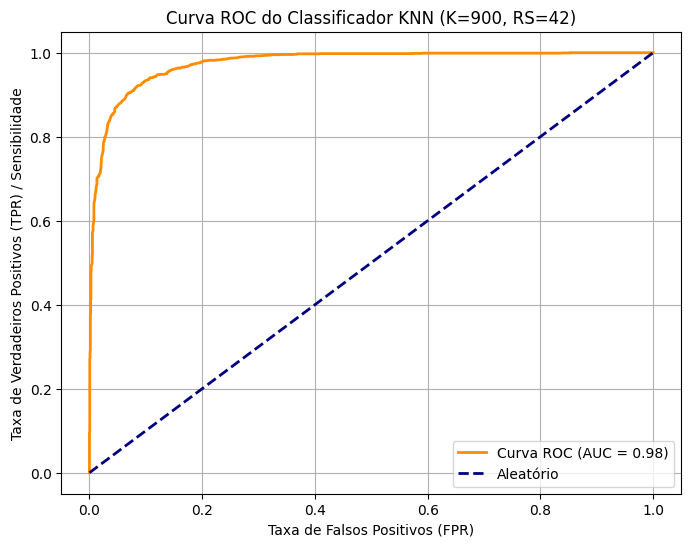

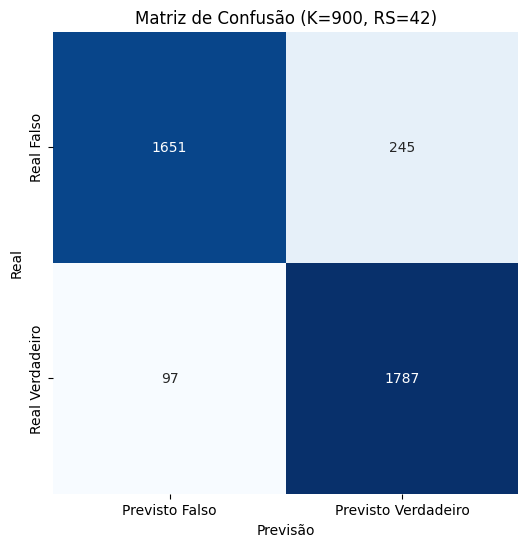

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import os

# --- Verificação e Download de Arquivos ---
true_csv_path = 'True.csv'
fake_csv_path = 'Fake.csv'

print("Verificando e garantindo a existência dos arquivos CSV...")

# Verificar e baixar True.csv
if not os.path.exists(true_csv_path):
    print(f"Arquivo '{true_csv_path}' não encontrado. Baixando...")
    !wget 'https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv'
else:
    print(f"Arquivo '{true_csv_path}' já existe.")

# Verificar e baixar Fake.csv
if not os.path.exists(fake_csv_path):
    print(f"Arquivo '{fake_csv_path}' não encontrado. Baixando...")
    !wget 'https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv'
else:
    print(f"Arquivo '{fake_csv_path}' já existe.")

print("Verificação e download concluídos. \n")

# ---

# --- Configurações Globais ---
FIXED_RANDOM_STATE = 42
LANGUAGE = 'english'
TFIDF_MAX_FEATURES = 5000
TFIDF_MIN_DF = 5
KFOLD_SPLITS = 5
# Valores de K para explorar: De 1 a 99 (ímpares) e K=100
K_VALUES_TO_EXPLORE = [775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100]
# K_VALUES_TO_EXPLORE = [100, 300, 600, 800, 1200, 1600, 2000]
# K_VALUES_TO_EXPLORE = list(range(401, 451, 2))
# if 100 not in K_VALUES_TO_EXPLORE:
    # K_VALUES_TO_EXPLORE.append(100)
K_VALUES_TO_EXPLORE.sort()

def load_and_prepare_data(true_csv_path: str, fake_csv_path: str) -> pd.DataFrame:
    """
    Carrega os datasets, seleciona apenas 'title' e 'text', adiciona rótulos e os concatena.

    Args:
        true_csv_path (str): Caminho para o arquivo CSV de notícias verdadeiras.
        fake_csv_path (str): Caminho para o arquivo CSV de notícias falsas.

    Returns:
        pd.DataFrame: DataFrame combinado e embaralhado, contendo apenas 'title', 'text' e 'label'.

    Raises:
        FileNotFoundError: Se um dos arquivos CSV não for encontrado.
        Exception: Para outros erros inesperados durante o carregamento.
    """
    print("1. Carregamento e Preparação dos Dados")

    # Nomes completos das colunas no CSV original para mapeamento de índice
    original_column_names = ['title', 'text', 'category', 'date']

    # Índices das colunas que queremos manter (title e text)
    title_idx = original_column_names.index('title')
    text_idx = original_column_names.index('text')

    # Definir as colunas que serão usadas pelo pandas
    use_cols_indices = [title_idx, text_idx]

    # Nomes das colunas após o carregamento (para as colunas selecionadas)
    selected_column_names = ['title', 'text']

    # Removido o bloco if not os.path.exists aqui, pois ele já é feito no início do script.
    # A função load_and_prepare_data agora assume que os arquivos existem ou que a exceção
    # FileNotFoundError será tratada pela função main, que a captura.

    try:
        # Usamos usecols para carregar apenas as colunas necessárias
        df_true = pd.read_csv(true_csv_path, header=None, names=original_column_names, usecols=use_cols_indices)
        df_fake = pd.read_csv(fake_csv_path, header=None, names=original_column_names, usecols=use_cols_indices)
        print("Datasets carregados com sucesso, focando em 'title' e 'text'!")
    except Exception as e:
        # Relançamos a exceção para que a função `main` a capture e lide com ela
        raise Exception(f"Erro inesperado ao carregar datasets: {e}")

    df_true['label'] = 1
    df_fake['label'] = 0
    df = pd.concat([df_true, df_fake], ignore_index=True)
    df = df.sample(frac=1, random_state=FIXED_RANDOM_STATE).reset_index(drop=True)

    # Combinar 'title' e 'text' em 'full_text'
    df['full_text'] = df['title'].fillna('') + " " + df['text'].fillna('')

    # Remover as colunas 'title' e 'text' se não forem mais necessárias após criar 'full_text'
    df = df.drop(columns=['title', 'text'])

    return df

def create_tfidf_features(X_train: pd.Series, X_test: pd.Series) -> tuple:
    """
    Cria as features TF-IDF para os conjuntos de treino e teste.

    Args:
        X_train (pd.Series): Dados de texto para treino.
        X_test (pd.Series): Dados de texto para teste.

    Returns:
        tuple: (X_train_tfidf, X_test_tfidf, tfidf_vectorizer)
    """
    print("\n2. Criação das Features (TF-IDF)")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=TFIDF_MAX_FEATURES, stop_words=LANGUAGE, min_df=TFIDF_MIN_DF
    )
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    print(f"Dimensões do X_train_tfidf: {X_train_tfidf.shape}")
    print(f"Dimensões do X_test_tfidf: {X_test_tfidf.shape}")
    return X_train_tfidf, X_test_tfidf, tfidf_vectorizer

def train_and_evaluate_knn_cv(X_train_tfidf, y_train: pd.Series, k_values: list) -> int:
    """
    Treina e avalia o modelo KNN usando validação cruzada para diferentes valores de K.

    Args:
        X_train_tfidf: Features TF-IDF do conjunto de treino.
        y_train (pd.Series): Rótulos do conjunto de treino.
        k_values (list): Lista de valores de K para explorar.

    Returns:
        int: O melhor valor de K encontrado.
    """
    print("\n3. Modelagem de K-Nearest Neighbors (KNN) e Avaliação de Modelos")
    print("\n--- Iniciando Validação Cruzada para diferentes valores de K ---")
    results_cv = {'K': [], 'Acurácia Média (Validação Cruzada)': [], 'Desvio Padrão (Validação Cruzada)': []}

    for k in k_values:
        print(f"Testando K = {k}...")
        knn_model = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(
            knn_model, X_train_tfidf, y_train,
            cv=KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=FIXED_RANDOM_STATE),
            scoring='accuracy', n_jobs=-1
        )
        results_cv['K'].append(k)
        results_cv['Acurácia Média (Validação Cruzada)'].append(np.mean(cv_scores))
        results_cv['Desvio Padrão (Validação Cruzada)'].append(np.std(cv_scores))

    results_df_cv = pd.DataFrame(results_cv)
    print("\nResultados da exploração de K via Validação Cruzada:")
    print(results_df_cv.round(4).to_string())

    if not results_df_cv.empty:
        best_k_cv = int(results_df_cv.loc[results_df_cv['Acurácia Média (Validação Cruzada)'].idxmax()]['K'])
        print(f"\nMelhor K selecionado baseado na MAIOR ACURÁCIA MÉDIA DA VALIDAÇÃO CRUZADA: {best_k_cv}")
    else:
        best_k_cv = 5 # Valor padrão caso não haja resultados (improvável)
        print(f"\nNão foi possível determinar o melhor K, usando um valor padrão de {best_k_cv}")
    return best_k_cv

def evaluate_binary_classifier(model, X_test_tfidf, y_test: pd.Series, best_k: int):
    """
    Avalia um classificador binário e exibe métricas e visualizações.

    Args:
        model: O modelo treinado.
        X_test_tfidf: Features TF-IDF do conjunto de teste.
        y_test (pd.Series): Rótulos reais do conjunto de teste.
        best_k (int): O melhor valor de K utilizado no modelo final.
    """
    print("\n4. Avaliação de Classificadores Binários (no conjunto de teste)")
    y_pred = model.predict(X_test_tfidf)
    y_prob = model.predict_proba(X_test_tfidf)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

    print(f"\n--- Métricas de Avaliação do Modelo Final (K={best_k}, RS={FIXED_RANDOM_STATE}) ---")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall (Sensibilidade): {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Especificidade: {specificity:.4f}")

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"Área sob a Curva ROC (AUC-ROC): {roc_auc:.4f} \n")

    # Visualização da Curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aleatório')
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR) / Sensibilidade')
    plt.title(f'Curva ROC do Classificador KNN (K={best_k}, RS={FIXED_RANDOM_STATE})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print() # Separar os gráficos com quebra de uma linha

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Previsto Falso', 'Previsto Verdadeiro'],
                yticklabels=['Real Falso', 'Real Verdadeiro'])
    plt.xlabel('Previsão')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão (K={best_k}, RS={FIXED_RANDOM_STATE})')
    plt.show()

def main():
    """Função principal para executar o pipeline de análise."""
    true_csv_path = 'True.csv'
    fake_csv_path = 'Fake.csv'

    try:
        # A verificação e download já foram feitos no início do script.
        # Aqui, a função load_and_prepare_data é chamada diretamente.
        df = load_and_prepare_data(true_csv_path, fake_csv_path)
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Erro fatal ao carregar dados: {e}")
        return

    X = df['full_text']
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=FIXED_RANDOM_STATE, stratify=y
    )
    print(f"Tamanho do conjunto de treino: {len(X_train)}")
    print(f"Tamanho do conjunto de teste: {len(X_test)}")

    X_train_tfidf, X_test_tfidf, _ = create_tfidf_features(X_train, X_test)

    best_k = train_and_evaluate_knn_cv(X_train_tfidf, y_train, K_VALUES_TO_EXPLORE)

    final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
    final_knn_model.fit(X_train_tfidf, y_train)
    print(f"Modelo KNN final treinado com K={best_k} e Random State={FIXED_RANDOM_STATE}.")

    evaluate_binary_classifier(final_knn_model, X_test_tfidf, y_test, best_k)

if __name__ == "__main__":
    main()